In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from jax import random, lax
from jax.experimental import optimizers
import jax.numpy as np
from jax.api import jit, jacfwd, vmap, value_and_grad
from jax.config import config
config.update('jax_enable_x64', True)
#config.update("jax_debug_nans", True)
from jax_md import simulate, space, energy, minimize, quantity
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from utils import ProgressIter, draw_system, lennard_jones_pair_no_cutoff, draw_lattice, params_to_matrices
from simulation import E_0, eV, species, displacement_fun, shift_fun

In [3]:
lattice_austenite_default = np.load("lattice_austenite.npz")["lattice_austenite"]
lattice_martensite_default = np.load("lattice_martensite.npz")["lattice_martensite"]

In [4]:
def simulate_with_parameters(
    e_aa, e_bb, e_ab,
    s_aa, s_bb, s_ab):
    epsilon, sigma = params_to_matrices(
        e_aa, e_bb, e_ab,
        s_aa, s_bb, s_ab)
    # To reproduce the paper in all its surface enrgy glory,
    # we compute all the pairwise interactions without a cutoff
    energy_fun = lennard_jones_pair_no_cutoff(
        displacement_fun, species=species, sigma=sigma, epsilon=epsilon)
    init_fun, apply_fun = minimize.fire_descent(
        energy_fun, shift_fun, dt_start=1e-3, dt_max=3e-3)
    return init_fun, apply_fun, energy_fun

In [5]:
OPTIMISATION_STEPS=500
def get_loss(initial_lattices, target_energy_diff, params):
    init_fun, apply_fun, energy_fun = simulate_with_parameters(**params)
    def get_lattice(initial_lattice):
         return lax.scan(lambda s, i: (apply_fun(s), ()),
                         init_fun(initial_lattice),
                         np.arange(OPTIMISATION_STEPS))[0].position
    new_lattices = vmap(get_lattice)(initial_lattices)
    new_energies = vmap(energy_fun)(new_lattices)
    return (new_energies[1] - new_energies[0] - target_energy_diff)**2, (new_lattices, new_energies)

In [6]:
opt_init, opt_update, get_params = optimizers.adam(1e-3)
default_params = {
    "e_aa":1.14,
    "e_ab":0.217,
    "e_bb":1.,
    "s_aa":0.9,
    "s_ab":0.6,
    "s_bb":0.865
}
opt_state = opt_init(default_params)
initial_lattices = np.array((lattice_martensite_default, lattice_austenite_default))

In [7]:
@jit
def produce_lattices_and_params(energy_delta):
    def optimisation_step(current_opt_state, iteration):
        params = get_params(current_opt_state)
        (loss, this_lattices), d_loss = value_and_grad(get_loss, argnums=(2), has_aux=True)(
            initial_lattices, energy_delta, params)
        new_opt_state = opt_update(iteration, d_loss, current_opt_state)
        return new_opt_state, (loss, this_lattices)
    last_opt_state, (losses, (lattices, energies)) = lax.scan(optimisation_step, opt_state, np.arange(100))
    return losses[-1], lattices[-1], energies[-1], get_params(last_opt_state)

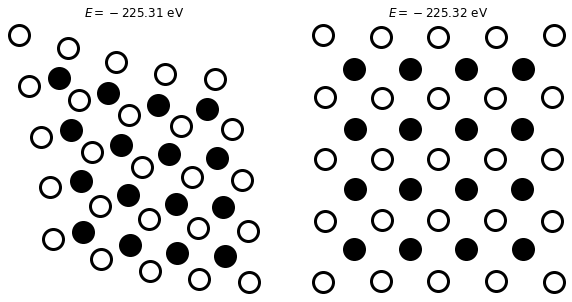

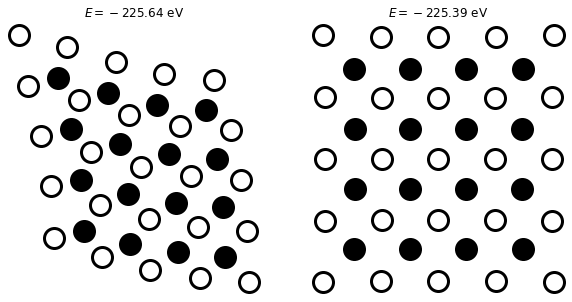

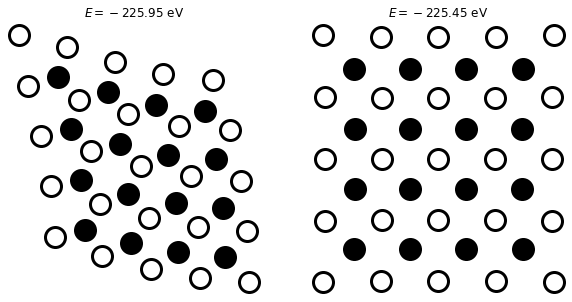

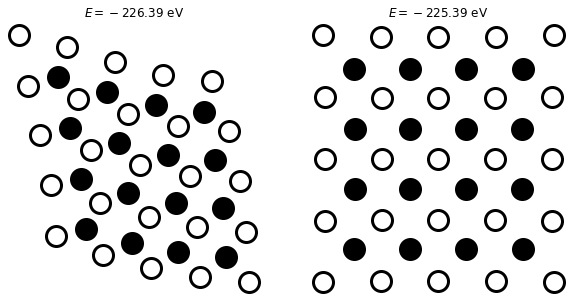

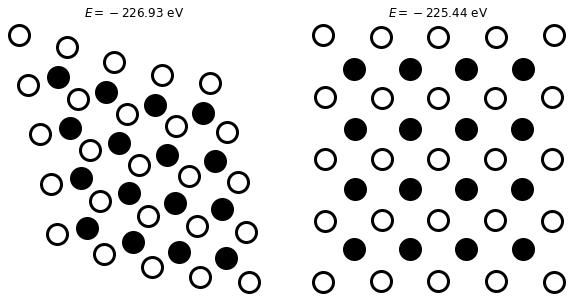

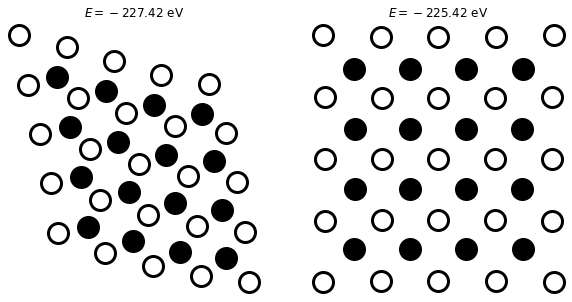

In [8]:
for energy_delta_eV in (0.,0.25,0.5,1.,1.5,2.):
    energy_delta = energy_delta_eV*eV/E_0
    loss, lattices, energies, params = produce_lattices_and_params(energy_delta)
    if loss > 0.1:
        print("Warning! Optimisation didn't converge")
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    for ax, lattice, energy in zip(axes, lattices, energies):
        draw_lattice(lattice, ax=ax)
        ax.set_title(f"$E={energy*E_0/eV:.2f}$ eV")
    epsilon, sigma = params_to_matrices(**params)
    np.savez(f"data/delta_{energy_delta_eV}_eV.npz",
             lattices=lattices.astype(np.float32),
             energies=energies.astype(np.float32),
             epsilon=epsilon.astype(np.float32),
             sigma=sigma.astype(np.float32))
    fig.savefig(f"plots/lattices_{energy_delta_eV}_eV.pdf", bbox_inches="tight")